原文链接：https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

In [5]:
import os
for dirname, _, filenames in os.walk('.\datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# 任何在这个工程文件夹的datasets子文件夹中的文件将被输出

#忽略警告
import warnings
warnings.filterwarnings('ignore')

.\datasets\items.csv
.\datasets\item_categories.csv
.\datasets\sales_train.csv
.\datasets\sample_submission.csv
.\datasets\shops.csv
.\datasets\test.csv


## 数据
我们获得了每个商店商品组合的每日销售数据，我们的任务是预测每月的销售额

## 导包

In [4]:
# 基本库
import numpy as np # 线性代数
import pandas as pd 
import random as rd # 生成随机数
import datetime # 控制日期数据
# 可视化
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# 时间序列
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# 设置
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Import all of them 
sales=pd.read_csv(r'.\datasets\sales_train.csv')

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv(r".\datasets\item_categories.csv")
item=pd.read_csv(r".\datasets\items.csv")
sub=pd.read_csv(r".\datasets\sample_submission.csv")
shops=pd.read_csv(r".\datasets\shops.csv")
test=pd.read_csv(r".\datasets\test.csv")

In [14]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [15]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [16]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [17]:
# 按照日期块（月份）、商店ID和商品ID进行分组聚合
# 选择列：日期、商品价格和商品销售数量
# 提供一个字典，指定在哪些列上执行什么类型的聚合操作
# 日期列进行最小值和最大值的聚合
# 商品价格列计算平均值
# 商品销售数量列计算总和
monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])[
    "date", "item_price", "item_cnt_day"].agg({
        "date": ["min", "max"],
        "item_price": "mean",
        "item_cnt_day": "sum"
    })

# 这里比较重要的是agg函数，简言之就是在不同的组里用不同的函数

In [19]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [27]:
item['haha']=1
item.head()

,item_name,item_id,item_category_id,haha
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,1
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,1
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,1
4,***КОРОБКА (СТЕКЛО) D,4,40,1


                  item_name  item_id  haha
item_category_id                          
0                         4        4     4
1                         2        2     2
2                        75       75    75
3                        34       34    34
4                        15       15    15
...                     ...      ...   ...
79                        1        1     1
80                        6        6     6
81                        7        7     7
82                        8        8     8
83                       15       15    15

[84 rows x 3 columns]


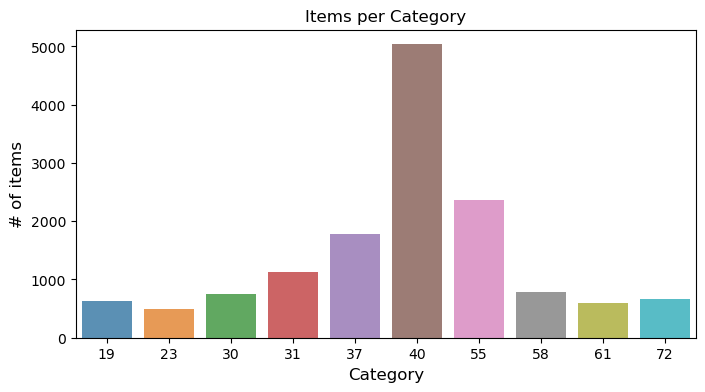

In [28]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
print(x)
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## 单系列预测

该目标要求我们预测商店商品组合下个月的销售额

每个商店商品随时间的销售量本身就是一个时间序列。 在我们深入研究所有组合之前，首先让我们了解如何预测单个系列

我选择预测整个公司每月的总销售额

首先，我们计算每月的总销售额并绘制该数据

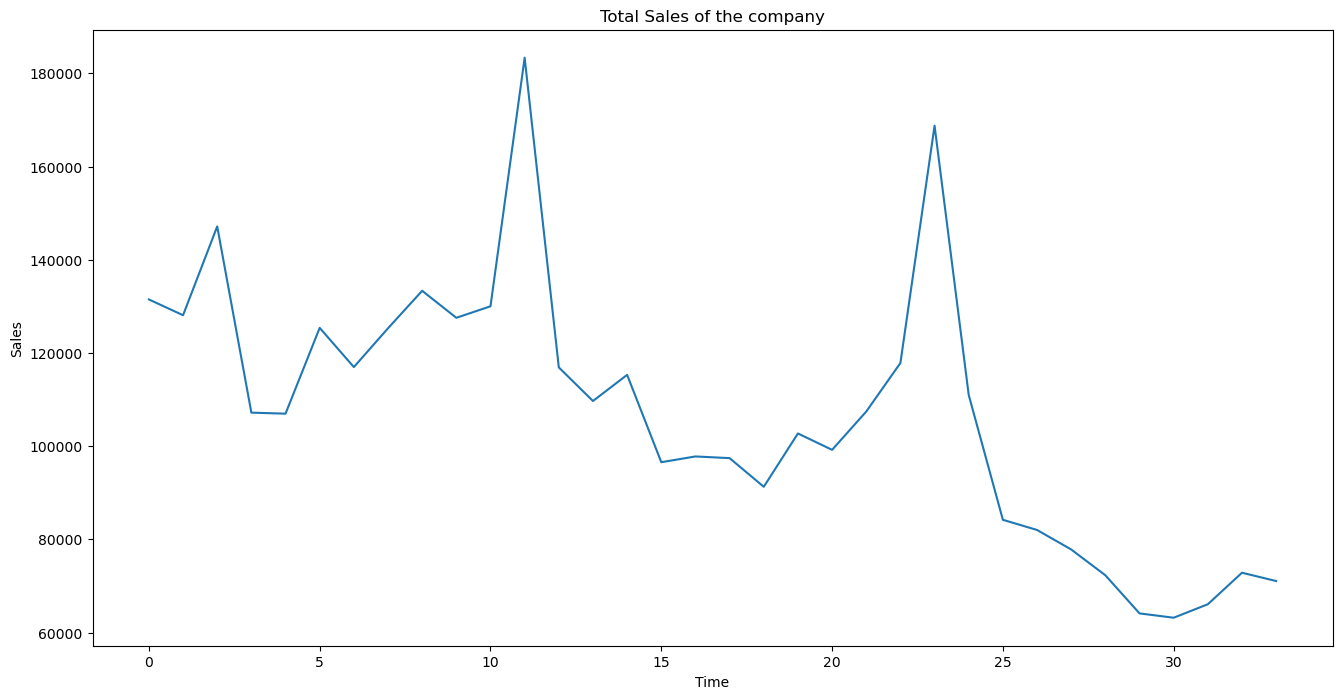

In [38]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

### 滑动窗口
计算滚动平均值和滚动标准差



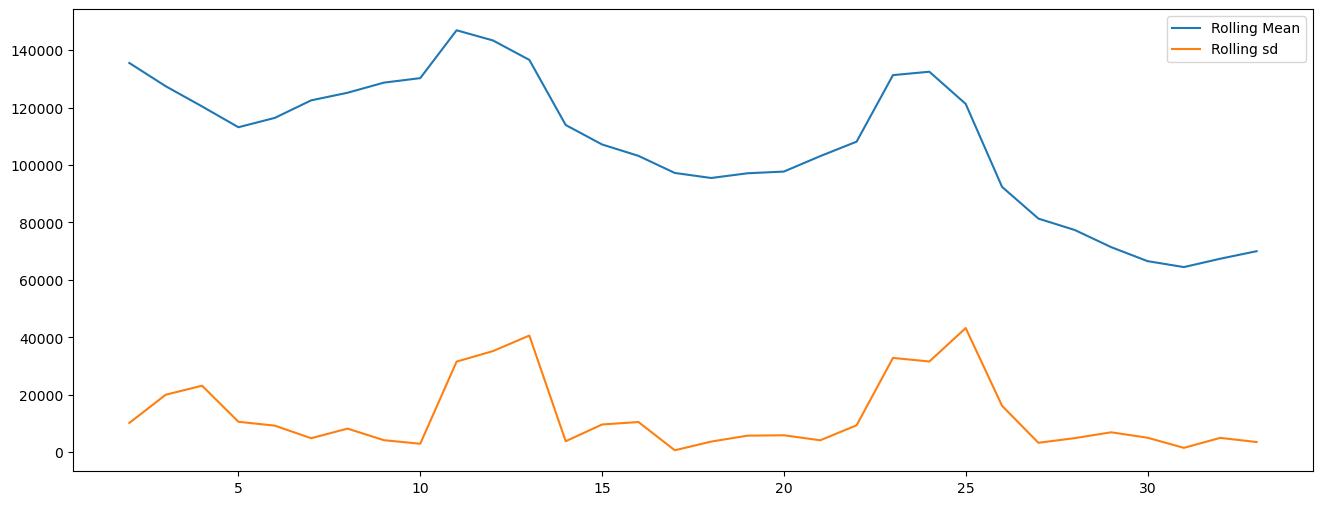

In [42]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=3,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=3,center=False).std(),label='Rolling sd');
plt.legend();

快速观察：存在明显的“季节性”（例如：一年中某个时间的销售高峰）和下降的“趋势”

让我们通过快速分解趋势、季节性和残差来检查这一点

> 这里window的单位是月份，原文中用了12，相当于以年为一个窗口，太大了，我调成了3，就有明显的季度特征了。不过原文可能说的是上一幅图


## 选择解释模型
加法模型（Additive Model）和乘法模型（Multiplicative Model）都是时间序列分解的方法，用于将时间序列数据分解为趋势、季节性和残差（剩余）三个部分。它们之间的区别在于如何将这些部分相加或相乘。

加法模型（Additive Model）：
在加法模型中，时间序列被分解为以下三个部分的加和：

趋势：数据中的长期趋势，表示数据的总体变化趋势。
季节性：周期性的波动，可以是固定周期（如每年、每月）的波动。
残差（剩余）：无法由趋势和季节性解释的部分，通常是随机噪声。
乘法模型（Multiplicative Model）：
在乘法模型中，时间序列被分解为以下三个部分的乘积：

趋势：数据中的长期趋势。
季节性：周期性的波动。
残差（剩余）：无法由趋势和季节性解释的部分。
选择加法模型还是乘法模型取决于数据的特征：

如果季节性的振幅在不同时间段保持相对稳定，即不随趋势变化而变化，那么可以选择使用加法模型。
如果季节性的振幅随着趋势的增长或减小而变化，即随趋势变化而变化，那么乘法模型可能更适用。
选择适当的模型有助于更准确地分析和预测时间序列数据的趋势和季节性。在实际应用中，可以尝试使用不同的分解方法，然后根据分解后的结果和数据的特点来选择合适的模型。

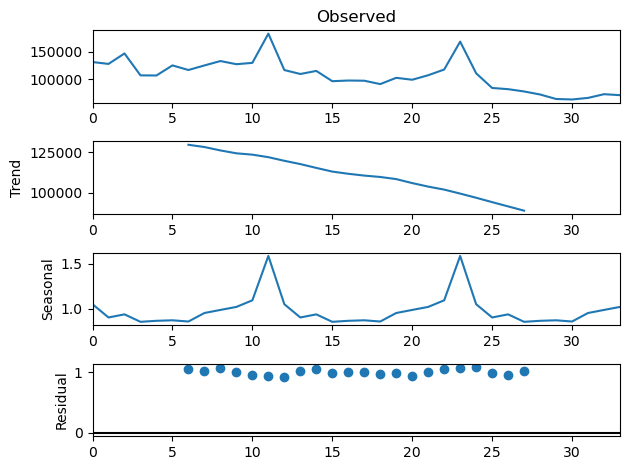

In [44]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

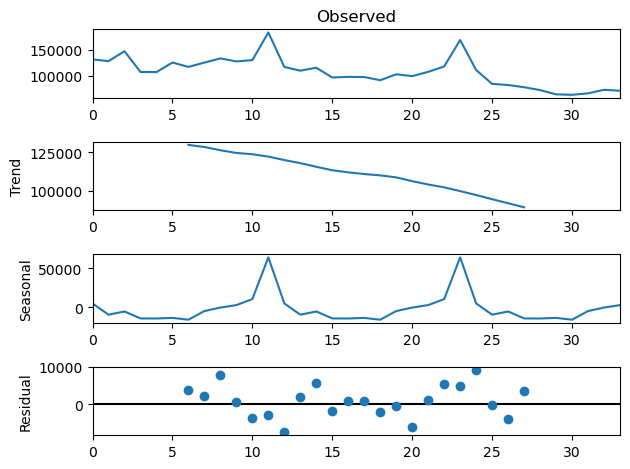

In [45]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### 关于参数period
在你的代码中，你使用了period=12，这意味着你认为数据中的季节性是在12个时间单位（可能是12个月）内重复一次。这可以帮助seasonal_decompose函数更好地理解数据中的季节性模式，从而进行季节性分解和绘制相应的图表。如果数据中的季节性周期是每年一次，那么设置period=12是合理的。如果季节性周期是其他时间单位，你需要相应地调整这个参数。

### 加法模型
我们假设一个加性模型，那么我们可以写作：

yt=St+Tt+Et

其中 yt 是周期 t 的数据，St 是周期 t 的季节性分量，Tt 是周期 tt 的趋势周期分量，Et 是周期 t 的余数（或不规则或误差）分量。对于乘法模型，类似地，我们有乘法模型：

yt=St x Tt x Et

## 平稳性
